# Marker gene database maker
The purpose of this jupyter notebook is to run through a workflow of creating a blast database containing protein sequences of a given gene from a wide range of taxonomic groups that can be used to validate newly submitted sequences against. 

Broadly, this process involves the following steps: 

1. Starting with an Entrez query for the Gene database, download sequences and metadata for genes, transcripts and proteins using esearch/efetch
2. Parse the data archive from step 1 to tabulate names and symbols for review
3. Parse the data archive from step 1 to tabulate variability in the sequence lengths for review 
4. Given a set of taxonomic group identifiers, tabulate the number of sequences for each group that are present in the data archive
5. Generate all-vs-all BLAST alignments 
6. Review the BLAST tabular output to make a list of accessions that are outliers or incorrect that need to be removed from the final BLAST database 
7. Generate a final BLAST database that can be used with VADR and other tools for validating newly submitted sequences.

In [1]:
import Bio
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import sys
import seaborn as sns
#import numpy as np
#from ete3 import NCBITaxa
#ncbi = NCBITaxa()
#ncbi.update_taxonomy_database()
import subprocess

/home/mcveigh/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Specify variables for Entrez query and download data

Sequence and metadata are downloaded using esearch and efetch using an Entrez query variables provided by the user. The full entrez query is encoded in script gene_uid_query.sh

"esearch -db gene -query "organism [ORGN] AND genename [GENE] mitochon AND alive [PROP] AND gene protein refseq [FILT] NOT rnatype mrna [PROP] NOT srcdb pdb [PROP] NOT uncultured NOT unverified" | efetch -format uid | sort -n | uniq"

Variables are:
1. gene (Name of gene (e.g., cytb))
2. organism (Limit query by taxonomic group (e.g., mammalia))
3. mitochondria (Restrict query to mitochondrial genes)

In [220]:
!gene_uid_query.sh -organism arthropoda -gene cytb -mito | obtain_gene_datasets.sh
gene_ids_file = 'gene_ids.txt'

Elapsed time 250 seconds


## Tabulate unique names

In [2]:
data_table = 'data_table.tsv'
gene_names = 'gene_names.tsv'

In [222]:
%%bash -s {data_table} {gene_names}

data_table=$1
gene_names=$2

python3 scripts/unique.py ${data_table} > ${gene_names}

In [3]:
df = pd.read_csv(gene_names, sep='\t', header=None, names=['Gene Name', 'Count', 'Gene IDs'])
display(df.sort_values(by=['Count'], ascending=False))

,Gene Name,Count,Gene IDs
0,10002870,1,CYTB
1921,39342643,1,CYTB
1923,39410806,1,CYTB
1924,39410817,1,CYTB
1925,39411388,1,CYTB
...,...,...,...
965,2847111,1,CYTB
966,2847184,1,CYTB
967,28479656,1,CYTB
968,28481279,1,CYTB


## Summarize data table and calculate tax stats

In [4]:
pd.set_option('display.max_rows', 500)
data_table_df = pd.read_csv(data_table, sep='\t', index_col=1)
data_table_df.rename(columns={"scientific_name": "taxname", "tax_id": "#taxid"}, inplace=True)
data_table_df.head(500)

,gene_symbol,taxname,#taxid,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
800081,CYTB,Triatoma dimidiata,72491,NC_002609.1:10252-11383,+,chr MT,NP_068653.1,377.0,cytochrome b
802322,CYTB,Lithobius forficatus,7552,NC_002629.1:8634-9767,+,chr MT,NP_071849.1,377.0,cytochrome b
802401,CYTB,Heterodoxus macropus,145266,NC_002651.1:4683-5783,+,chr MT,NP_073761.1,366.0,cytochrome b
802590,CYTB,Cochliomyia hominivorax,115425,NC_002660.1:11607-12743,+,chr MT,NP_075459.1,378.0,cytochrome b
802687,CYTB,Chrysomya putoria,235600,NC_002697.1:10410-11546,+,chr MT,NP_085093.1,378.0,cytochrome b
802999,CYTB,Tetrodontophora bielanensis,48717,NC_002735.1:10302-11435,+,chr MT,NP_112432.1,377.0,cytochrome b
803775,CYTB,Limulus polyphemus,6850,NC_003057.1:8783-9914,+,chr MT,NP_150612.1,377.0,cytochrome b
803801,CYTB,Pagurus longicarpus,111067,NC_003058.1:14269-15405,+,chr MT,NP_150627.1,378.0,cytochrome b
803817,CYTB,Tribolium castaneum,7070,NC_003081.2:10280-11417,+,chr MT,NP_203166.1,379.0,cytochrome b


In [5]:
data_table_df.to_csv('taxid_list', index=False, header=False, sep ='\t', columns=['#taxid'])
os.system("/panfs/pan1.be-md.ncbi.nlm.nih.gov/protein_clusters/BIN/nodesByStaxID -in taxid_list -ranks phylum,class,order,family,genus,species > lineage")
tax_report = (r'lineage')
lineage_df = pd.read_csv(tax_report, sep='\t', index_col=None, na_values=['-'])
lineage_df

,#taxid,taxname,phylum,class,order,family,genus,species
0,72491,Triatoma dimidiata,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
1,7552,Lithobius forficatus,Arthropoda,Chilopoda,Lithobiomorpha,Lithobiidae,Lithobius,NaN
2,145266,Heterodoxus macropus,Arthropoda,Insecta,Phthiraptera,Boopidae,Heterodoxus,NaN
3,115425,Cochliomyia hominivorax,Arthropoda,Insecta,Diptera,Calliphoridae,Cochliomyia,NaN
4,235600,Chrysomya putoria,Arthropoda,Insecta,Diptera,Calliphoridae,Chrysomya,NaN
...,...,...,...,...,...,...,...,...
2886,2807723,Eristalinus quinquestriatus,Arthropoda,Insecta,Diptera,Syrphidae,Eristalinus,NaN
2887,655083,Pterodecta felderi,Arthropoda,Insecta,Lepidoptera,Callidulidae,Pterodecta,NaN
2888,1395520,Spondylis buprestoides,Arthropoda,Insecta,Coleoptera,Cerambycidae,Spondylis,NaN
2889,640304,Chrysolina aeruginosa,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Chrysolina,NaN


In [6]:
lineage2_df = lineage_df.drop(columns=['taxname'])
table_combined = pd.merge(left=data_table_df, right=lineage2_df, left_on='#taxid', right_on='#taxid')
table_combined.drop_duplicates(subset=['protein_accession'], inplace=True)
table_combined.drop(columns=['genomic_range', 'orientation', 'location', 'gene_symbol', 'protein_name'], inplace=True)
table_combined
#if table_combined['class'].isnull().values.any():
#    print("found nan")

,taxname,#taxid,protein_accession,protein_length,phylum,class,order,family,genus,species
0,Triatoma dimidiata,72491,NP_068653.1,377.0,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
1,Lithobius forficatus,7552,NP_071849.1,377.0,Arthropoda,Chilopoda,Lithobiomorpha,Lithobiidae,Lithobius,NaN
2,Heterodoxus macropus,145266,NP_073761.1,366.0,Arthropoda,Insecta,Phthiraptera,Boopidae,Heterodoxus,NaN
3,Cochliomyia hominivorax,115425,NP_075459.1,378.0,Arthropoda,Insecta,Diptera,Calliphoridae,Cochliomyia,NaN
4,Chrysomya putoria,235600,NP_085093.1,378.0,Arthropoda,Insecta,Diptera,Calliphoridae,Chrysomya,NaN
...,...,...,...,...,...,...,...,...,...,...
2890,Eristalinus quinquestriatus,2807723,YP_009995543.1,378.0,Arthropoda,Insecta,Diptera,Syrphidae,Eristalinus,NaN
2891,Pterodecta felderi,655083,YP_009995908.1,381.0,Arthropoda,Insecta,Lepidoptera,Callidulidae,Pterodecta,NaN
2892,Spondylis buprestoides,1395520,YP_009995921.1,379.0,Arthropoda,Insecta,Coleoptera,Cerambycidae,Spondylis,NaN
2893,Chrysolina aeruginosa,640304,YP_009995934.1,379.0,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Chrysolina,NaN


## Evaluate numbers of sequences in different taxonomic groupings

In [7]:
pd.set_option('display.max_rows', 500)
#lineage_df.groupby('class').count()
#count = table_combined.groupby('class').count()
count = table_combined.groupby('class').size()
count.to_csv('taxsummary', sep='\t')
table_combined.groupby('class').count().head(500)

,taxname,#taxid,protein_accession,protein_length,phylum,order,family,genus,species
class,,,,,,,,,
Arachnida,173,173,173,173,173,173,171,173,0
Branchiopoda,22,22,22,22,22,22,21,22,1
Chilopoda,6,6,6,6,6,6,6,6,0
Collembola,21,21,21,21,21,21,21,21,0
Diplopoda,9,9,9,9,9,9,9,8,0
Hexanauplia,38,38,38,38,38,38,38,38,0
Ichthyostraca,4,4,4,4,4,4,4,4,0
Insecta,2223,2223,2223,2223,2223,2223,2223,2221,24
Malacostraca,370,370,370,370,370,370,370,370,1


## Make smaller dataframes for further analysis by tax group

In [8]:
taxset_df = table_combined[table_combined['family'] == "Culicidae"]
taxset_acc = taxset_df['protein_accession']
taxset_acc.to_csv('taxset_acclist', index = False, header = None)
taxset_df


,taxname,#taxid,protein_accession,protein_length,phylum,class,order,family,genus,species
31,Anopheles quadrimaculatus A,42377,NP_008697.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
34,Anopheles gambiae,7165,NP_008080.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
76,Aedes albopictus,7160,YP_194922.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Aedes,NaN
285,Anopheles darlingi,43151,YP_003734752.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
307,Culex quinquefasciatus,7176,YP_003934133.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Culex,NaN
332,Culex pipiens pipiens,38569,YP_004221859.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Culex,Culex pipiens
518,Anopheles albitarsis,58236,YP_007625573.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
519,Anopheles deaneorum,58243,YP_007625586.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
520,Anopheles cracens,123217,YP_007626951.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
521,Anopheles hinesorum,59189,YP_007626964.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN


# Alignments

### Create a full alignment of all data

In [229]:
os.system("muscle -in protein.faa -fastaout protein_all_aln -clwout protein_all_clw -maxiters 1 -diags -sv -distance1 kbit20_3 ")

0

### Full alignment summary

In [230]:
os.system("esl-alistat --amino protein_all_aln > align_all_summary")
with open("align_all_summary", "r") as ping2:
    print(ping2.read())

Alignment number:    1
Format:              aligned FASTA
Number of sequences: 2891
Alignment length:    459
Total # residues:    1091637
Smallest:            350
Largest:             397
Average length:      377.6
Average identity:    67%
//



### Optional create fasta file containing a subset of data as defined in taxset_df data slice

In [170]:
from Bio import SeqIO
sequences = []  
for seq_record in SeqIO.parse("protein.faa", "fasta"): 
    s = seq_record
    if seq_record.id in taxset_df['protein_accession'].tolist():
        sequences.append(s)
SeqIO.write(sequences, 'protein_sorted.faa', "fasta")  

108

### Optional align the subset of data created above

In [171]:
os.system("muscle -in protein_sorted.faa -fastaout protein_aln -clwout protein_clw -maxiters 1 -diags -sv -distance1 kbit20_3 ")

0

### Optional statistics on subset alignment created above

In [13]:
os.system("esl-alistat --amino protein_aln > align_summary")
with open("align_summary", "r") as ping:
    print(ping.read())

Alignment number:    1
Format:              aligned FASTA
Number of sequences: 108
Alignment length:    378
Total # residues:    40824
Smallest:            378
Largest:             378
Average length:      378.0
Average identity:    93%
//



### Generate full alignment statistics for every taxa

In [9]:
import glob
protein_acc_list = [[x, y, table_combined[table_combined[x] == y].protein_accession.to_list()] for x in ['phylum', 'class', 'order', 'family', 'genus'] for y in table_combined[x].unique()]
for x in protein_acc_list:
    number_of_acc = []
    rank = x[0]
    taxa = x[1]
    protsub_list = x[2]
    if taxa != "NaN":
        number_of_acc = len(protsub_list)
        if (number_of_acc > 1):
            fname = "data/"+taxa+"_accs.txt"
            fout = taxa+"_alnsum"
            with open(fname, 'w') as f:
                for i in protsub_list:
                    f.write(i+'\n')
            subprocess.run(['esl-reformat --informat afa stockholm protein_all_aln | esl-alimanip --seq-k "$1" - | esl-alistat - > data/"$2" ', 'arg0', fname,  fout], text=True, shell=True)

all_files = glob.glob("data/*alnsum")           
li = [] 
taxaname = []
df = pd.concat([pd.read_csv(filename, sep=':', low_memory=False, header=None, names=["description", "value"]).assign(taxa=os.path.basename(filename).split('_')[0]) for filename in all_files])
li.append(df)
alnsum_df = pd.concat(li, axis=0, ignore_index=True)
#alnsum_df
align_percent = alnsum_df[alnsum_df['description'] == "Average identity"]
align_percent['taxa'] = align_percent['taxa'].str.strip()
align_percent
#align_percent.to_csv(r'align_percent_summary', sep ='\t', index = True)            
            
            

/home/mcveigh/jup/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,description,value,taxa
8,Average identity,71%,Insecta
18,Average identity,62%,Chilopoda
28,Average identity,72%,Collembola
38,Average identity,87%,Merostomata
48,Average identity,74%,Malacostraca
...,...,...,...
7808,Average identity,100%,Chionoecetes
7818,Average identity,67%,Arthropoda
7828,Average identity,88%,Hydraenidae
7838,Average identity,94%,Hemigrapsus


In [232]:
align_percent.to_csv(r'align_percent_summary', sep ='\t', index = True)  

### skip this for now alignment review all in python. slicing the alignments into subsets based on tax rank works fine but calculating %identity of the subalignment isn't working. code executes but is very slow

In [ ]:
from Bio import SeqIO
from itertools import combinations
#sequences = [] 
fullalign = 'protein_all_aln'
protein_acc_list = [[x, y, table_combined[table_combined[x] == y].protein_accession.to_list()] for x in ['class'] for y in table_combined[x].unique()]
for x in protein_acc_list:
    sequences = [] 
    number_of_acc = []
    infile = 'taxset_summary'
    rank = x[0]
    taxa = x[1]
    #print(taxa)
    protsub_list = x[2]
    if taxa != "NaN":
        number_of_acc = len(protsub_list)
        if (number_of_acc > 1):
            fname = taxa+"_aln"
            for seq_record in SeqIO.parse(fullalign, "fasta"): 
                s = seq_record
                str_id = seq_record.id
                if seq_record.id in protsub_list:
                    sequences.append(s)
        comp_length = 0
        num_sim = 0        
        for record1, record2 in combinations(sequences, 2):
            sequence1 = record1.seq
            sequence2 = record2.seq
            for pos in range(0, min(len(sequence1), len(sequence2))):
                #if (sequence1[pos] != '-') and (sequence2[pos] != '-'):
                    #comp_length += 1
                    #if sequence1[pos] == sequence2[pos]:
                        #num_sim += 1
            #score = num_sim  / comp_length
            #print(taxa, score)
        
                if sequence1[pos] == sequence2[pos]:
                    a += 2
                if sequence1[pos] != sequence2[pos]:
                    a += -1
                if sequence1[pos] == sequence2[pos] == '-':
                    a += -2
        print(taxa, a)
  
             
                    
            
 


# Sequence Analysis

## Identify outliers based on protein size

In [233]:
data_table_df[['protein_length']].describe()

,protein_length
count,2891.000000
mean,377.598409
std,4.875855
min,350.000000
25%,377.000000
50%,378.000000
75%,379.000000
max,397.000000


<AxesSubplot:ylabel='Density'>

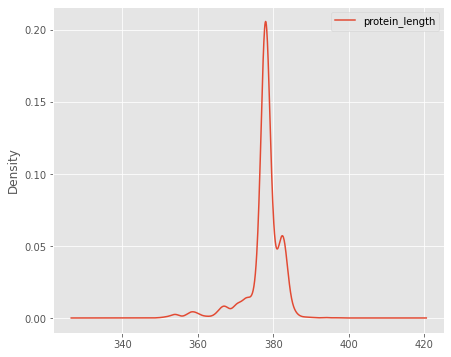

In [234]:
data_table_df.plot(kind='kde', y='protein_length', figsize=(7,6))


### Report Sequences that are too short or too long

In [235]:
#identify sequences outside of length range for analsysis
wronglength = data_table_df.loc[(data_table_df['protein_length'] < 350) | (data_table_df['protein_length'] > 390)]
wronglength

,gene_symbol,taxname,#taxid,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
14412034,CYTB,Polycheles typhlops,512014,NC_020026.1:13220-14404,+,chr MT,YP_007317402.1,394.0,cytochrome b
16488854,CYTB,Appalachioria falcifera,382869,NC_021933.1:13095-14279,+,chr MT,YP_008378738.1,394.0,cytochrome b
19909943,CYTB,Xenophyes cascus,984453,NC_024622.1:4092-5285,-,chr MT,YP_009049549.1,397.0,cytochrome b
22832667,CYTB,Lethe dura,1457180,NC_026062.1:10410-11585,+,chr MT,YP_009114186.1,391.0,cytochrome b


### Remove sequences that are too short or too long           

In [236]:
## filter out sequences that are either too long or too short

min_len = 349
max_len = 391

rightlength = data_table_df.loc[(data_table_df['protein_length'] > min_len) & (data_table_df['protein_length'] < max_len)]
#rightlength.to_csv("rightlength", sep='\t')
rightlength.head()
#acclist = rightlength['protein_accession']
#rightlength.to_csv('taxmap', index=False, header=False, sep ='\t', columns=['protein_accession', 'tax_id'])
#print(acclist)

,gene_symbol,taxname,#taxid,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
800081,CYTB,Triatoma dimidiata,72491,NC_002609.1:10252-11383,+,chr MT,NP_068653.1,377.0,cytochrome b
802322,CYTB,Lithobius forficatus,7552,NC_002629.1:8634-9767,+,chr MT,NP_071849.1,377.0,cytochrome b
802401,CYTB,Heterodoxus macropus,145266,NC_002651.1:4683-5783,+,chr MT,NP_073761.1,366.0,cytochrome b
802590,CYTB,Cochliomyia hominivorax,115425,NC_002660.1:11607-12743,+,chr MT,NP_075459.1,378.0,cytochrome b
802687,CYTB,Chrysomya putoria,235600,NC_002697.1:10410-11546,+,chr MT,NP_085093.1,378.0,cytochrome b


In [237]:
from Bio import SeqIO
sequences = [] 
for seq_record in SeqIO.parse("protein.faa", "fasta"): 
    s = seq_record    
    if seq_record.id in rightlength['protein_accession'].tolist():
        sequences.append(s)
    else:
        print("removed accessions are: ", seq_record.id)
SeqIO.write(sequences, "stripped.fsa", "fasta")  



removed accessions are:  YP_007317402.1
removed accessions are:  YP_008378738.1
removed accessions are:  YP_009049549.1
removed accessions are:  YP_009114186.1


2887

## Generate taxmap and save for later use

In [239]:
rightlength.to_csv('taxmap', index=False, header=False, sep ='\t', columns=['protein_accession', '#taxid'])

## Run all-vs-all BLAST

In [240]:
#!scripts/blast_all.sh -b {bdbag} -a {acclist_for_blast} -t 6
os.system("makeblastdb -in stripped.fsa -parse_seqids -dbtype prot -taxid_map taxmap -out prot_blastdb")
os.system("blastp -db prot_blastdb -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")
#os.system("blast_formatter -archive blastout.asn -outfmt '7 std staxid ssciname' -out blastout.tsv")
#os.system("blastp -db nr -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")

0

## Read BLAST tsv file, remove matches to self
This creates a master file of the blast output with the organism names and taxids

In [10]:
file_name_string = (r'blastout.tsv')
table_df = pd.read_csv(file_name_string,
                       sep='\t',
                       index_col=None,
                       low_memory=False,
                       usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                       header=None,
                       names=["queryseqid", "subjectseqid", "identity", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "Evalue", "bitscore", "qcoverage", "taxid", "taxname"])
table_df = table_df[~table_df['queryseqid'].str.contains("#")]
table_df['%identity'] = pd.to_numeric(table_df['identity'])
table_df['length'] = pd.to_numeric(table_df['length'])
table_df['qstart'] = pd.to_numeric(table_df['qstart'])
table_df['qend'] = pd.to_numeric(table_df['qend'])
table_df['sstart'] = pd.to_numeric(table_df['sstart'])
table_df['send'] = pd.to_numeric(table_df['send'])
table_df['qcoverage'] = pd.to_numeric(table_df['qcoverage'])
#table_df
#strip .version if needed
#table_df['taxid'] = table_df['taxid'].astype(str)
#table_df['taxid'] = table_df['taxid'].map(lambda x: str(x)[:-2])
#table_df['queryseqid'] = table_df['queryseqid'].astype(int)
#table_df['queryseqid'] = table_df['queryseqid'].map(lambda x: int(x)[:-1])
table2_df = table_df.loc[(table_df['queryseqid']) != (table_df['subjectseqid'])]
table2_df.drop(['mismatch', 'gapopen', 'bitscore', '%identity'], axis=1, inplace=True)
table2_df

/home/mcveigh/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,queryseqid,subjectseqid,identity,length,qstart,qend,sstart,send,Evalue,qcoverage,taxid,taxname
6,NP_068653.1,YP_009919166.1,97.878,377.0,1.0,377.0,1.0,377.0,0.0,100.0,98665.0,Triatoma mazzottii
7,NP_068653.1,YP_009919148.1,97.878,377.0,1.0,377.0,1.0,377.0,0.0,100.0,2086892.0,Triatoma huehuetenanguensis
8,NP_068653.1,YP_009919200.1,96.552,377.0,1.0,377.0,1.0,377.0,0.0,100.0,72494.0,Triatoma sanguisuga
9,NP_068653.1,YP_009919135.1,93.634,377.0,1.0,377.0,1.0,377.0,0.0,100.0,340914.0,Triatoma mexicana
10,NP_068653.1,YP_009412498.1,90.691,376.0,1.0,376.0,1.0,376.0,0.0,99.0,30076.0,Triatoma infestans
...,...,...,...,...,...,...,...,...,...,...,...,...
1457943,YP_009995947.1,YP_009058474.1,71.892,370.0,5.0,374.0,8.0,377.0,0.0,98.0,7370.0,Musca domestica
1457944,YP_009995947.1,YP_009045505.1,72.162,370.0,7.0,376.0,13.0,382.0,0.0,98.0,191423.0,Parthenos sylvia
1457945,YP_009995947.1,YP_009045258.1,71.654,381.0,1.0,376.0,2.0,382.0,0.0,100.0,882614.0,Athyma sinope
1457946,YP_009995947.1,YP_009026957.1,72.703,370.0,7.0,376.0,10.0,378.0,0.0,98.0,627747.0,Leptomantella albella


## Create a smaller dataframe with just numberical values

In [11]:
dftidy = table2_df.drop(['taxid', 'taxname'], axis=1)
dftidy

,queryseqid,subjectseqid,identity,length,qstart,qend,sstart,send,Evalue,qcoverage
6,NP_068653.1,YP_009919166.1,97.878,377.0,1.0,377.0,1.0,377.0,0.0,100.0
7,NP_068653.1,YP_009919148.1,97.878,377.0,1.0,377.0,1.0,377.0,0.0,100.0
8,NP_068653.1,YP_009919200.1,96.552,377.0,1.0,377.0,1.0,377.0,0.0,100.0
9,NP_068653.1,YP_009919135.1,93.634,377.0,1.0,377.0,1.0,377.0,0.0,100.0
10,NP_068653.1,YP_009412498.1,90.691,376.0,1.0,376.0,1.0,376.0,0.0,99.0
...,...,...,...,...,...,...,...,...,...,...
1457943,YP_009995947.1,YP_009058474.1,71.892,370.0,5.0,374.0,8.0,377.0,0.0,98.0
1457944,YP_009995947.1,YP_009045505.1,72.162,370.0,7.0,376.0,13.0,382.0,0.0,98.0
1457945,YP_009995947.1,YP_009045258.1,71.654,381.0,1.0,376.0,2.0,382.0,0.0,100.0
1457946,YP_009995947.1,YP_009026957.1,72.703,370.0,7.0,376.0,10.0,378.0,0.0,98.0


## Groupby and Aggregate the top ten rows of blast results

In [12]:
table3_df = dftidy.groupby('queryseqid').head(10) 
ident_group = table3_df.groupby('queryseqid').agg(['median', 'min', 'max']) 
ident_group

identity                  length               qstart            \
              median     min      max median    min    max median  min  max   
queryseqid                                                                    
NP_006913.1  96.4285  91.005   99.735  378.0  378.0  378.0    1.0  1.0  1.0   
NP_007119.1  77.2610  72.872   92.819  376.0  373.0  376.0    6.0  6.0  9.0   
NP_007301.1  92.5930  91.293   99.208  378.0  378.0  379.0    1.0  1.0  1.0   
NP_008080.1  99.4710  98.677  100.000  378.0  378.0  378.0    1.0  1.0  1.0   
NP_008093.1  91.3155  69.737   99.217  380.0  379.0  383.0    1.0  1.0  1.0   
...              ...     ...      ...    ...    ...    ...    ...  ...  ...   
YP_961309.1  90.2370  89.182   92.084  379.0  379.0  379.0    1.0  1.0  1.0   
YP_961393.1  99.6030  98.148  100.000  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973126.1  91.2695  90.476   98.677  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973139.1  87.5660  87.037   88.095  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973152.1  89.1530  88.889   96.032  378.0  378.0  378.0    1.0  1.0  1.0   

              qend  ... sstart   send               Evalue            \
            median  ...    max median    min    max median  min  max   
queryseqid          ...                                                
NP_006913.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_007119.1  381.0  ...    5.0  376.0  376.0  377.0    0.0  0.0  0.0   
NP_007301.1  378.0  ...    1.0  378.0  378.0  379.0    0.0  0.0  0.0   
NP_008080.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_008093.1  380.0  ...    1.0  380.0  379.0  383.0    0.0  0.0  0.0   
...            ...  ...    ...    ...    ...    ...    ...  ...  ...   
YP_961309.1  379.0  ...    1.0  379.0  379.0  379.0    0.0  0.0  0.0   
YP_961393.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973126.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973139.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973152.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   

            qcoverage                
               median    min    max  
queryseqid                           
NP_006913.1     100.0  100.0  100.0  
NP_007119.1      99.0   98.0   99.0  
NP_007301.1      99.0   99.0  100.0  
NP_008080.1     100.0  100.0  100.0  
NP_008093.1      99.0   99.0  100.0  
...               ...    ...    ...  
YP_961309.1     100.0  100.0  100.0  
YP_961393.1     100.0  100.0  100.0  
YP_973126.1     100.0  100.0  100.0  
YP_973139.1     100.0  100.0  100.0  
YP_973152.1     100.0  100.0  100.0  

[2887 rows x 24 columns]

## Convert back to one dimentional index for searborn

In [13]:
ident_group.columns = ident_group.columns.map('_'.join)
ident_group.columns.get_level_values(0)


Index(['identity_median', 'identity_min', 'identity_max', 'length_median',
       'length_min', 'length_max', 'qstart_median', 'qstart_min', 'qstart_max',
       'qend_median', 'qend_min', 'qend_max', 'sstart_median', 'sstart_min',
       'sstart_max', 'send_median', 'send_min', 'send_max', 'Evalue_median',
       'Evalue_min', 'Evalue_max', 'qcoverage_median', 'qcoverage_min',
       'qcoverage_max'],
      dtype='object')

In [245]:
ident_group

,identity_median,identity_min,identity_max,length_median,length_min,length_max,qstart_median,qstart_min,qstart_max,qend_median,...,sstart_max,send_median,send_min,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max
queryseqid,,,,,,,,,,,,,,,,,,,,,
NP_006913.1,96.4285,91.005,99.735,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_007119.1,77.2610,72.872,92.819,376.0,373.0,376.0,6.0,6.0,9.0,381.0,...,5.0,376.0,376.0,377.0,0.0,0.0,0.0,99.0,98.0,99.0
NP_007301.1,92.5930,91.293,99.208,378.0,378.0,379.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,379.0,0.0,0.0,0.0,99.0,99.0,100.0
NP_008080.1,99.4710,98.677,100.000,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_008093.1,91.3155,69.737,99.217,380.0,379.0,383.0,1.0,1.0,1.0,380.0,...,1.0,380.0,379.0,383.0,0.0,0.0,0.0,99.0,99.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_961309.1,90.2370,89.182,92.084,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,1.0,379.0,379.0,379.0,0.0,0.0,0.0,100.0,100.0,100.0
YP_961393.1,99.6030,98.148,100.000,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
YP_973126.1,91.2695,90.476,98.677,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0


In [246]:
ident_group.to_csv(r'ident_group_file', sep ='\t', index = True)

## Let's plot the query coverage data to visual

<AxesSubplot:ylabel='Density'>

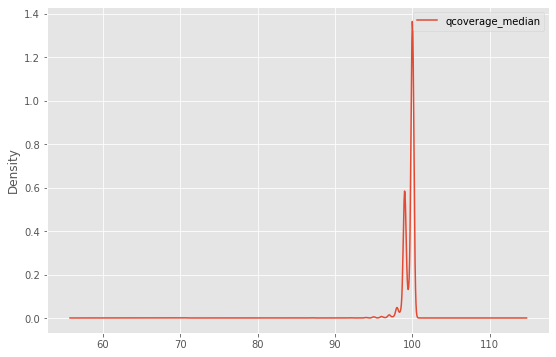

In [247]:
ident_group.plot(kind='kde', y='qcoverage_median', figsize=(9,6))
#ident_group.savefig('qcov_median.png')

## Median %identity

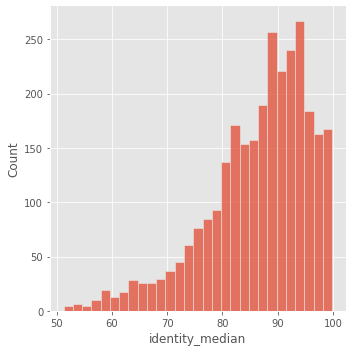

<Figure size 432x288 with 0 Axes>

In [248]:
sns.displot(ident_group.identity_median.dropna())
plt.show()
plt.savefig('identity_displot.png')

## Identify sequences with values below the pass/fail thresholds %identity and query coverage

### Determine taxonomic relationships of the organisms in the top ten BLAST returns per query

In [14]:
table5_df = table_df.groupby('queryseqid')['queryseqid', 'subjectseqid', 'taxname'].head(11)
#table5_df.drop_duplicates(subset=['taxname'], inplace=True)
#table5_df['taxid'] = table5_df['taxid'].astype(int)
table5_df.to_csv(r'table5_df', sep ='\t', index = True)
table5_df

/home/mcveigh/jup/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,queryseqid,subjectseqid,taxname
5,NP_068653.1,NP_068653.1,Triatoma dimidiata
6,NP_068653.1,YP_009919166.1,Triatoma mazzottii
7,NP_068653.1,YP_009919148.1,Triatoma huehuetenanguensis
8,NP_068653.1,YP_009919200.1,Triatoma sanguisuga
9,NP_068653.1,YP_009919135.1,Triatoma mexicana
...,...,...,...
1457454,YP_009995947.1,YP_009573032.1,Podagricomela nigricollis
1457455,YP_009995947.1,YP_009417320.1,Acanthoscelides obtectus
1457456,YP_009995947.1,YP_009139865.1,Galeruca daurica
1457457,YP_009995947.1,YP_009528989.1,Monolepta quadriguttata


In [15]:
table8_df = pd.merge(left=table5_df, right=lineage_df, left_on='taxname', right_on='taxname', how='left')
table8_df.to_csv(r'table8_df', sep ='\t', index = True)
table8_df

,queryseqid,subjectseqid,taxname,#taxid,phylum,class,order,family,genus,species
0,NP_068653.1,NP_068653.1,Triatoma dimidiata,72491,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
1,NP_068653.1,YP_009919166.1,Triatoma mazzottii,98665,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
2,NP_068653.1,YP_009919148.1,Triatoma huehuetenanguensis,2086892,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
3,NP_068653.1,YP_009919200.1,Triatoma sanguisuga,72494,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
4,NP_068653.1,YP_009919135.1,Triatoma mexicana,340914,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
...,...,...,...,...,...,...,...,...,...,...
31774,YP_009995947.1,YP_009573032.1,Podagricomela nigricollis,2528270,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Podagricomela,NaN
31775,YP_009995947.1,YP_009417320.1,Acanthoscelides obtectus,200917,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Acanthoscelides,NaN
31776,YP_009995947.1,YP_009139865.1,Galeruca daurica,1651263,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Galeruca,NaN
31777,YP_009995947.1,YP_009528989.1,Monolepta quadriguttata,1254971,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Monolepta,NaN


In [16]:
group_lineage = table8_df.groupby('queryseqid')
common_rank = []
for name, group in group_lineage:  
    uniques = []
    taxvalue = []
    uniques = group['genus'].nunique(dropna=True)
    if uniques == 1:
        #print(name, group['genus'])
        taxvalue = name, group['genus']
        #print(taxvalue)
        common_rank.append(taxvalue)
    elif uniques > 1:
        uniques = group['family'].nunique(dropna=True)
        if uniques == 1:
            taxvalue = name, group['family']
            #print(taxvalue)
            common_rank.append(taxvalue)
        elif uniques > 1:
            uniques = group['order'].nunique(dropna=True)
            if uniques == 1:
                taxvalue = name, group['order']
                #print(taxvalue)
                common_rank.append(taxvalue)
            elif uniques > 1:
                uniques = group['class'].nunique(dropna=True) 
                if uniques == 1:
                    taxvalue = name, group['class']
                    #print(taxvalue)
                    common_rank.append(taxvalue)
                elif uniques > 1:
                    uniques = group['phylum'].nunique(dropna=True) 
                    if uniques == 1:
                        taxvalue = name, group['phylum']
                        #print(taxvalue)
                        common_rank.append(taxvalue)
#print(common_rank) 

In [17]:
f = open('commonranks', 'w')
for t in common_rank:
    line = ' '.join(str(x) for x in t)
    f.write(line + '\n')
f.close()

In [209]:
#align_percent['taxa'] = align_percent['taxa'].str.strip()
#align_percent

In [175]:
#align_data = pd.read_csv("align_percent_summary", sep='\t', index_col=None)
#align_data.drop(columns=['Unnamed: 0'], inplace=True)

#align_data.dtypes


description    object
value          object
taxa           object
dtype: object

In [23]:
commonrank = pd.DataFrame(common_rank, columns = ['queryseqid', 'taxa']) 
commonrank['taxa'] = commonrank['taxa'].astype(str)
commonrank['taxa'] = commonrank['taxa'].str.replace('\d+', '')
commonrank['taxa'] = commonrank['taxa'].str.replace('\n', ' ')
commonrank['taxa'] = commonrank['taxa'].str.replace('NaN', '')
commonrank['taxa'] = commonrank['taxa'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')
commonrank['taxa'] = commonrank['taxa'].str.split('Name').str[0]
#commonrank['taxa'] = commonrank['taxa'].astype(object)
commonrank['taxa'] = commonrank['taxa'].str.strip()
commonrank.head(100)
###CHECK HERE FOR NANs they may be missing

,queryseqid,taxa
0,NP_006913.1,Diptera
1,NP_007119.1,Arthropoda
2,NP_007301.1,Acrididae
3,NP_008080.1,Anopheles
4,NP_008093.1,Apidae
5,NP_008508.1,Ixodidae
6,NP_008522.1,Ixodidae
7,NP_008632.1,Arthropoda
8,NP_008658.1,Tephritidae
9,NP_008697.1,Anopheles


In [34]:
rankidentity = pd.merge(left=commonrank, right=align_percent, on='taxa')
rankidentity.to_csv(r'rankidentity', sep ='\t', index = True) 
rankidentity['value'] = rankidentity['value'].str.replace('%', '')
rankidentity

,queryseqid,taxa,description,value
0,NP_006913.1,Diptera,Average identity,83
1,NP_982320.1,Diptera,Average identity,83
2,NP_982333.1,Diptera,Average identity,83
3,NP_987118.1,Diptera,Average identity,83
4,YP_003097124.1,Diptera,Average identity,83
...,...,...,...,...
2882,YP_009995465.1,Ochthebius,Average identity,88
2883,YP_009995478.1,Ochthebius,Average identity,88
2884,YP_009995491.1,Ochthebius,Average identity,88
2885,YP_009995504.1,Ochthebius,Average identity,88


In [46]:
masterident = pd.merge(left=ident_group, right=rankidentity, left_on='queryseqid', right_on='queryseqid', how='left')
masterident.to_csv(r'masterident', sep ='\t', index = True) 
masterident['identity_median'] = pd.to_numeric(masterident['identity_median'])
#masterident['value'] = pd.to_numeric(masterident['value'])
masterident['value'] = masterident['value'].astype(int)
masterident.set_index(['queryseqid'], inplace = True)
masterident

,identity_median,identity_min,identity_max,length_median,length_min,length_max,qstart_median,qstart_min,qstart_max,qend_median,...,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max,taxa,description,value
queryseqid,,,,,,,,,,,,,,,,,,,,,
NP_006913.1,96.4285,91.005,99.735,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,378.0,0.0,0.0,0.0,100.0,100.0,100.0,Diptera,Average identity,83
NP_007119.1,77.2610,72.872,92.819,376.0,373.0,376.0,6.0,6.0,9.0,381.0,...,377.0,0.0,0.0,0.0,99.0,98.0,99.0,Arthropoda,Average identity,67
NP_007301.1,92.5930,91.293,99.208,378.0,378.0,379.0,1.0,1.0,1.0,378.0,...,379.0,0.0,0.0,0.0,99.0,99.0,100.0,Acrididae,Average identity,89
NP_008080.1,99.4710,98.677,100.000,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,378.0,0.0,0.0,0.0,100.0,100.0,100.0,Anopheles,Average identity,98
NP_008093.1,91.3155,69.737,99.217,380.0,379.0,383.0,1.0,1.0,1.0,380.0,...,383.0,0.0,0.0,0.0,99.0,99.0,100.0,Apidae,Average identity,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_961309.1,90.2370,89.182,92.084,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,379.0,0.0,0.0,0.0,100.0,100.0,100.0,Hexanauplia,Average identity,74
YP_961393.1,99.6030,98.148,100.000,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,378.0,0.0,0.0,0.0,100.0,100.0,100.0,Tephritidae,Average identity,95
YP_973126.1,91.2695,90.476,98.677,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,378.0,0.0,0.0,0.0,100.0,100.0,100.0,Syrphidae,Average identity,93


### Lookup the expected %identity of the specific tax group for each query and use this to populate identity_max number for the pass/fail selection

In [47]:
identity_low = masterident.loc[(masterident['identity_max'] < masterident['value'])].index.tolist()
#len(identity_low)
identity_low

['NP_073761.1',
 'NP_075459.1',
 'NP_758884.1',
 'YP_001552109.1',
 'YP_001837107.1',
 'YP_001936591.1',
 'YP_002242164.1',
 'YP_002317256.1',
 'YP_002317282.1',
 'YP_002735002.1',
 'YP_002889407.1',
 'YP_002907411.1',
 'YP_003097124.1',
 'YP_003204693.1',
 'YP_003734739.1',
 'YP_003735167.1',
 'YP_003848771.1',
 'YP_003875575.1',
 'YP_004841759.1',
 'YP_004842321.1',
 'YP_004857899.1',
 'YP_004934971.1',
 'YP_005087986.1',
 'YP_005353019.1',
 'YP_006234167.1',
 'YP_006234429.1',
 'YP_006503894.1',
 'YP_006503907.1',
 'YP_006503920.1',
 'YP_006665907.1',
 'YP_006665933.1',
 'YP_006883042.1',
 'YP_007474879.1',
 'YP_007517107.1',
 'YP_008963766.1',
 'YP_008993153.1',
 'YP_009020947.1',
 'YP_009050360.1',
 'YP_009054394.1',
 'YP_009073498.1',
 'YP_009092379.1',
 'YP_009104522.1',
 'YP_009114522.1',
 'YP_009121683.1',
 'YP_009126970.1',
 'YP_009127082.1',
 'YP_009130787.1',
 'YP_009131558.1',
 'YP_009142440.1',
 'YP_009157863.1',
 'YP_009172215.1',
 'YP_009172228.1',
 'YP_009172241.1',
 '

In [42]:
qcov_low = ident_group[ident_group['qcoverage_min'] < 90].index.tolist()
qcov_low 

['YP_001218728.1',
 'YP_002836178.1',
 'YP_007025136.1',
 'YP_009306447.1',
 'YP_009945379.1',
 'YP_271856.1']

## Sort fasta file creating two files [1] seqs that pass [2] seqs that fail

In [48]:
from Bio import SeqIO
sequences = [] 
fail_sequence = []
for seq_record in SeqIO.parse("stripped.fsa", "fasta"):
    s = seq_record
    if seq_record.id in identity_low:
        print("fails seq identity test", seq_record.id)
        fail_sequence.append(s)
    elif seq_record.id in qcov_low:
        fail_sequence.append(s)
        print("fails qcov test",seq_record.id)
    else:
        sequences.append(s)
        #print(seq_record.id)
        
SeqIO.write(sequences, "outputfile", "fasta")

fails seq identity test NP_073761.1
fails seq identity test NP_075459.1
fails seq identity test NP_758884.1
fails seq identity test YP_025747.1
fails seq identity test YP_026063.1
fails seq identity test YP_026051.1
fails seq identity test YP_073318.1
fails seq identity test YP_086825.1
fails qcov test YP_271856.1
fails seq identity test YP_740081.1
fails seq identity test YP_863647.1
fails qcov test YP_001218728.1
fails seq identity test YP_001552109.1
fails seq identity test YP_001837107.1
fails seq identity test YP_001936591.1
fails seq identity test YP_002242164.1
fails seq identity test YP_002317282.1
fails seq identity test YP_002317256.1
fails seq identity test YP_002735002.1
fails qcov test YP_002836178.1
fails seq identity test YP_002889407.1
fails seq identity test YP_002907411.1
fails seq identity test YP_003097124.1
fails seq identity test YP_003204693.1
fails seq identity test YP_003734739.1
fails seq identity test YP_003735167.1
fails seq identity test YP_003848771.1
fail

2750

In [49]:
sh = open("protein.faa")
num = 0
for line in sh:
    if line.startswith(">"):
        num += 1
sh.close()
print("Number of sequences in the starting input file:", num)

Number of sequences in the starting input file: 2891


In [50]:
fh = open("outputfile")
n = 0
for line in fh:
    if line.startswith(">"):
        n += 1
fh.close()
print("Number of sequences passing all validation tests and saved to outputfile:", n)

Number of sequences passing all validation tests and saved to outputfile: 2750
